## Transports of water and tracer along several cross-sections of the base case

Transports across several cross sections in the domain (See plot further down)

Water transport calculated as $\Phi_w = \vec{u}\cdot\vec{a}$

Advective tracer transport $\Phi_{Tadv}=C\vec{u}\cdot\vec{a}$ from model output diagnostics.

Diffusive tracer transport $\Phi_{Tdiff}$ from model output (Includes diffusion due to advection scheme)

Frequency of output is 43200 s (half a day) and the size of the fields is 360x360x90x20.


For passive tracers units correspond to what I entered as units in data.ptracers but it really doesn't matter.

Filename: FluxTR01 

| Variable    |   Units                        | Description  | Coordinates           | Size                      |
|------------ | :----------------------------: |:-------------|:---------------------:|:--------------------------:
| UTRAC01     |  $Mol\ l^{-1}\cdot ms^{-1}$    |Zonal Mass-Weighted Transp of Tr01   | (T, Z, Y, Xp1) | (18,90,360,361)
| VTRAC01     |  $Mol\ l^{-1}\cdot ms^{-1}$    |Meridional Mass-Weighted Transp of Tr01|(T, Z, Yp1, X) | (18,90,361,360)
| WTRAC01     |  $Mol\ l^{-1}\cdot ms^{-1}$    |Vertical Mass-Weighted Transp of Tr01|(T, Z, Y, X) | (18,90,360,360)
| ADVrTr01    |  $Mol\ l^{-1}\cdot m^3s^{-1}$  |Vertical Advective Flux of Tr01|(T, Z, Y, X) | (18,90,360,360)
| ADVxTr01    |  $Mol\ l^{-1}\cdot m^3s^{-1}$  |Zonal Advective Flux of Tr01 |(T, Z, Y, Xp1) | (18,90,360,361)
| ADVyTr01    |  $Mol\ l^{-1}\cdot m^3s^{-1}$  |Meridional Advective Flux of Tr01|(T, Z, Yp1, X) | (18,90,361,360)
| DFrETr01    |  $Mol\ l^{-1}\cdot m^3s^{-1}$  |Vertical Diffusive Flux of Tr01 (Explicit part)|(T, Z, Y, X)| (18,90,360,360)
| DFxETr01    |  $Mol\ l^{-1}\cdot m^3s^{-1}$  | Zonal      Diffusive Flux of Tr01|(T, Z, Y, Xp1) | (18,90,360,361)
| DFyETr01    |  $Mol\ l^{-1}\cdot m^3s^{-1}$  | Meridional Diffusive Flux of Tr01|(T, Z, Yp1, X) | (18,90,361,360)
| DFrITr01    |  $Mol\ l^{-1}\cdot m^3s^{-1}$  | Vertical Diffusive Flux of Tr01 (Implicit part)| (T, Z, Y, X) | (18,90,360,360) 
 

In [226]:
import datetime as dtm      # Python's standard date and time library
import dateutil as dutil    # Powerful datetime extensions
import glob
from math import *
from matplotlib.dates import num2date
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import xarray as xr


In [163]:
def calc_wat_transport_CS(vel_component, x_slice, y_slice, spacing, dim_name):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. unstagger_xarray(state03.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    spacing: xarray, width of cross section elements (e.g. dxG, etc)
    dim_name: str, name of the dimension along which to sum.
    
    '''
    vel_CS = (vel_component.isel(Yp1=y_slice, X=x_slice))
    dx_CS = (spacing.isel(Yp1=y_slice, X=x_slice))

    waterCS_flux = (dx_CS*vel_CS).sum(dim=dim_name)

    return waterCS_flux

def calc_wat_transport_AS(vel_component, x_slice, y_slice, spacing, dim_name):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. unstagger_xarray(state03.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    spacing: xarray, width of cross section elements (e.g. dxG, etc)
    dim_name: str, name of the dimension along which to sum.
    
    '''
    vel_AS = (vel_component.isel(Y=y_slice, Xp1=x_slice))
    dx_AS = (spacing.isel(Y=y_slice, Xp1=x_slice))

    waterAS_flux = (dx_AS*vel_AS).sum(dim=dim_name)

    return waterAS_flux

def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty

def fig_looks(ax, title = 'Cross-shelf transport'):
    '''define aesthetics of transport plots'''
    sns.set_style(style='whitegrid')
    sns.set_context('talk')

    ax.set_ylabel('Water transport [$m^3s^{-1}$]')
    ax.set_xlabel('Time [$s$]')
    ax.legend(loc=0)
    ax.set_title(title)
    
    return(ax)
    

In [99]:
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
state_file03 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/stateGlob.nc'
ptracers_file03 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/ptracersGlob.nc'


grid = xr.open_dataset(grid_file)
state03 = xr.open_dataset(state_file03)
tracers03 = xr.open_dataset(ptracers_file03)

### Cross-sections

In [100]:
CS1_x_slice = slice(0, 59)
CS2_x_slice = slice(60, 119)
CS3_x_slice = slice(120, 239)
CS4_x_slice = slice(240, 299)
CS5_x_slice = slice(300, 359)

CS1_y_ind = 227
CS1b_y_ind = 267
CS1c_y_ind = 297
CS1d_y_ind = 359

AS1_y_slice = slice(227, 266)
AS2_y_slice = slice(267, 298)
AS3_y_slice = slice(269, 359)

AS1_x_ind = 59
AS1b_x_ind = 119
AS1c_x_ind = 239
AS1d_x_ind = 299

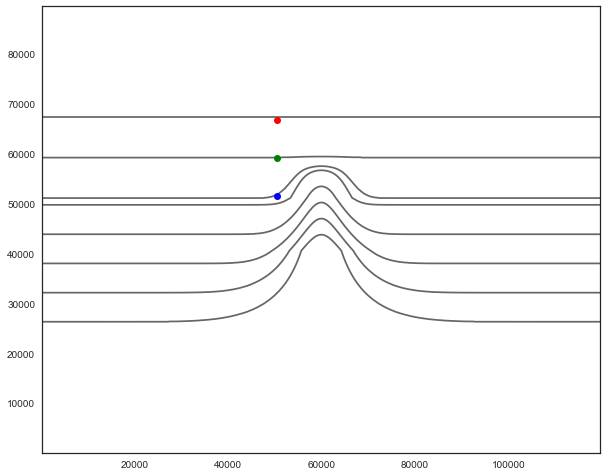

In [101]:
sns.set_style(style='white')
fig, ax = plt.subplots(1, 1, figsize=(10,8))

ax.contour(grid.X,grid.Y,grid.Depth,[50,100,150,200,400,600,800,1000], colors='0.4')
ax.plot(grid.X[120],grid.Y[227], 'bo')
ax.plot(grid.X[120],grid.Y[267], 'go')
ax.plot(grid.X[120],grid.Y[297], 'ro')

In [146]:
waterCS1_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS1_x_slice, CS1_y_ind,
                                      unstagger_xarray(grid.dxG, 'Yp1'), 'X')
waterCS2_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS2_x_slice, CS1_y_ind,
                                      unstagger_xarray(grid.dxG, 'Yp1') , 'X')
waterCS3_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS3_x_slice, CS1_y_ind,
                                      unstagger_xarray(grid.dxG, 'Yp1') , 'X')
waterCS4_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS4_x_slice, CS1_y_ind,
                                      unstagger_xarray(grid.dxG, 'Yp1') , 'X')
waterCS5_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS5_x_slice, CS1_y_ind,
                                      unstagger_xarray(grid.dxG, 'Yp1') , 'X')

waterCS1_flux.name = 'WaterFlux_CS1'
waterCS1_flux.attrs['units'] = 'm2/s'
waterCS2_flux.name = 'WaterFlux_CS2'
waterCS2_flux.attrs['units'] = 'm2/s'
waterCS3_flux.name = 'WaterFlux_CS3'
waterCS3_flux.attrs['units'] = 'm2/s'
waterCS4_flux.name = 'WaterFlux_CS4'
waterCS4_flux.attrs['units'] = 'm2/s'
waterCS5_flux.name = 'WaterFlux_CS5'
waterCS5_flux.attrs['units'] = 'm2/s'

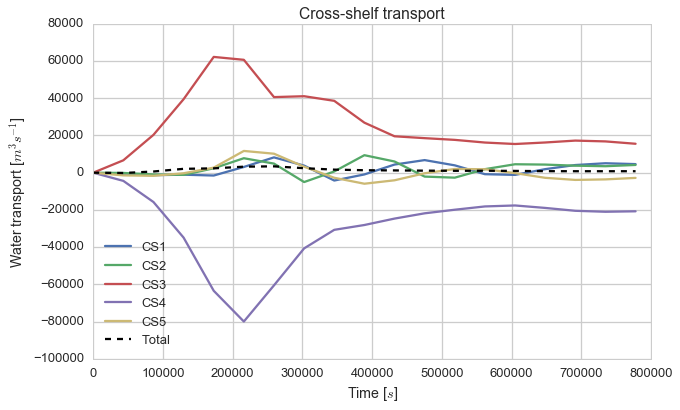

In [169]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS1_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS1')
(waterCS2_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS2')
(waterCS3_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS3')
(waterCS4_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS4')
(waterCS5_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS5') 

(waterCS1_flux*grid.drF+
 waterCS2_flux*grid.drF+
 waterCS3_flux*grid.drF+
 waterCS4_flux*grid.drF+
 waterCS5_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'Total', color='k',linestyle='--')

ax = fig_looks(ax)

From 100m down


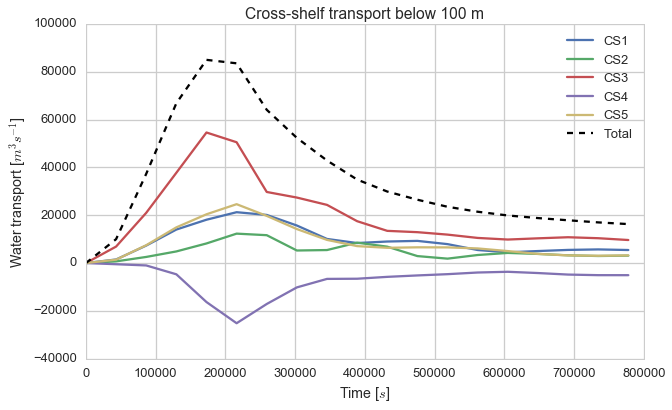

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS1_flux*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS1')
(waterCS2_flux*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS2')
(waterCS3_flux*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS3')
(waterCS4_flux*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS4')
(waterCS5_flux*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'CS5') 

(waterCS1_flux*grid.drF+
 waterCS2_flux*grid.drF+
 waterCS3_flux*grid.drF+
 waterCS4_flux*grid.drF+
 waterCS5_flux*grid.drF).isel(Z=slice(20,90)).sum(dim='Z').plot(ax=ax, label = 'Total', color='k',linestyle='--')

print('From 100m down')

ax = fig_looks(ax, title = 'Cross-shelf transport below 100 m')

Above 100m


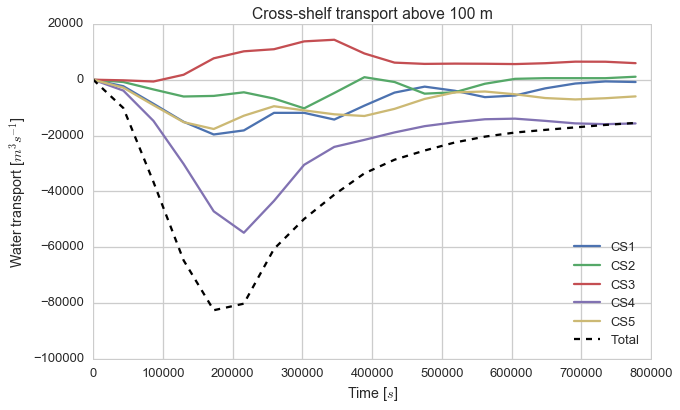

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS1_flux*grid.drF).isel(Z=slice(0,20)).sum(dim='Z').plot(ax=ax, label = 'CS1')
(waterCS2_flux*grid.drF).isel(Z=slice(0,20)).sum(dim='Z').plot(ax=ax, label = 'CS2')
(waterCS3_flux*grid.drF).isel(Z=slice(0,20)).sum(dim='Z').plot(ax=ax, label = 'CS3')
(waterCS4_flux*grid.drF).isel(Z=slice(0,20)).sum(dim='Z').plot(ax=ax, label = 'CS4')
(waterCS5_flux*grid.drF).isel(Z=slice(0,20)).sum(dim='Z').plot(ax=ax, label = 'CS5') 

(waterCS1_flux*grid.drF+
 waterCS2_flux*grid.drF+
 waterCS3_flux*grid.drF+
 waterCS4_flux*grid.drF+
 waterCS5_flux*grid.drF).isel(Z=slice(0,20)).sum(dim='Z').plot(ax=ax, label = 'Total', color='k',linestyle='--')

print('Above 100m')

ax = fig_looks(ax, title = 'Cross-shelf transport above 100 m')

Below shelf-break depth


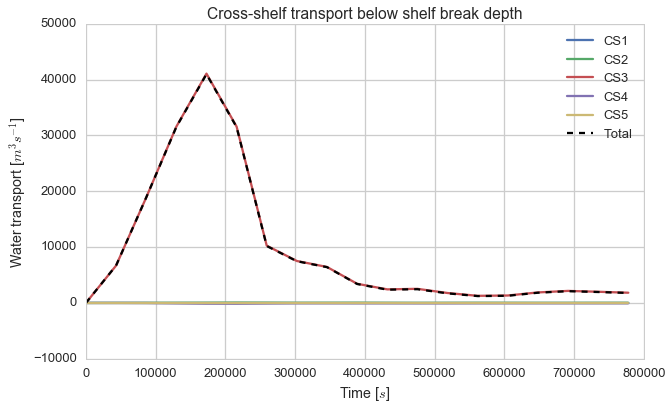

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS1_flux*grid.drF).isel(Z=slice(30,90)).sum(dim='Z').plot(ax=ax, label = 'CS1')
(waterCS2_flux*grid.drF).isel(Z=slice(30,90)).sum(dim='Z').plot(ax=ax, label = 'CS2')
(waterCS3_flux*grid.drF).isel(Z=slice(30,90)).sum(dim='Z').plot(ax=ax, label = 'CS3')
(waterCS4_flux*grid.drF).isel(Z=slice(30,90)).sum(dim='Z').plot(ax=ax, label = 'CS4')
(waterCS5_flux*grid.drF).isel(Z=slice(30,90)).sum(dim='Z').plot(ax=ax, label = 'CS5') 

(waterCS1_flux*grid.drF+
 waterCS2_flux*grid.drF+
 waterCS3_flux*grid.drF+
 waterCS4_flux*grid.drF+
 waterCS5_flux*grid.drF).isel(Z=slice(30,90)).sum(dim='Z').plot(ax=ax, label = 'Total', color='k',linestyle='--')

print('Below shelf-break depth')

ax = fig_looks(ax, title = 'Cross-shelf transport below shelf break depth')

### How much water goes beyond 100 m?

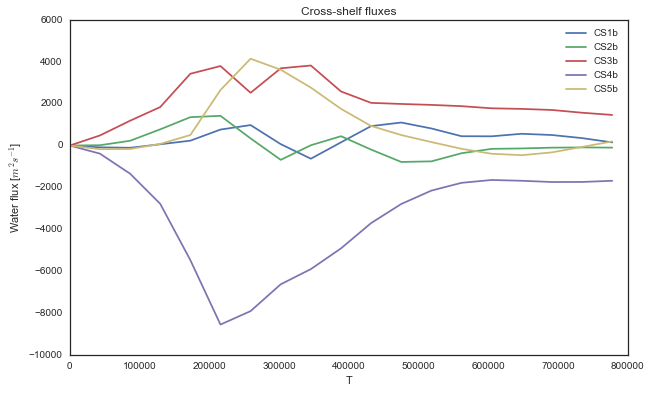

In [73]:
waterCS1b_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS1_x_slice, CS1b_y_ind, unstagger_xarray(grid.dxG, 'Yp1') , 'X')
waterCS2b_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS2_x_slice, CS1b_y_ind, unstagger_xarray(grid.dxG, 'Yp1') , 'X')
waterCS3b_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS3_x_slice, CS1b_y_ind, unstagger_xarray(grid.dxG, 'Yp1') , 'X')
waterCS4b_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS4_x_slice, CS1b_y_ind, unstagger_xarray(grid.dxG, 'Yp1') , 'X')
waterCS5b_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS5_x_slice, CS1b_y_ind, unstagger_xarray(grid.dxG, 'Yp1') , 'X')

waterCS1b_flux.name = 'WaterFlux_CS1b'
waterCS1b_flux.attrs['units'] = 'm2/s'
waterCS2b_flux.name = 'WaterFlux_CS2b'
waterCS2b_flux.attrs['units'] = 'm2/s'
waterCS3b_flux.name = 'WaterFlux_CS3b'
waterCS3b_flux.attrs['units'] = 'm2/s'
waterCS4b_flux.name = 'WaterFlux_CS4b'
waterCS4b_flux.attrs['units'] = 'm2/s'
waterCS5b_flux.name = 'WaterFlux_CS5b'
waterCS5b_flux.attrs['units'] = 'm2/s'



at 100 m isobath


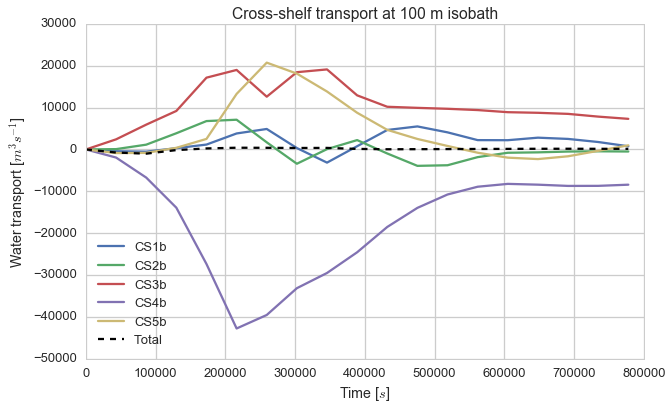

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS1b_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS1b')
(waterCS2b_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS2b')
(waterCS3b_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS3b')
(waterCS4b_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS4b')
(waterCS5b_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS5b') 

(waterCS1b_flux*grid.drF+
 waterCS2b_flux*grid.drF+
 waterCS3b_flux*grid.drF+
 waterCS4b_flux*grid.drF+
 waterCS5b_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'Total', color='k',linestyle='--')

print('at 100 m isobath')

ax = fig_looks(ax, title = 'Cross-shelf transport at 100 m isobath')



### How much water goes beyond 50 m?

In [179]:
waterCS1c_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS1_x_slice, CS1c_y_ind, unstagger_xarray(grid.dxG, 'Yp1') , 'X')
waterCS2c_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS2_x_slice, CS1c_y_ind, unstagger_xarray(grid.dxG, 'Yp1') , 'X')
waterCS3c_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS3_x_slice, CS1c_y_ind, unstagger_xarray(grid.dxG, 'Yp1') , 'X')
waterCS4c_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS4_x_slice, CS1c_y_ind, unstagger_xarray(grid.dxG, 'Yp1') , 'X')
waterCS5c_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS5_x_slice, CS1c_y_ind, unstagger_xarray(grid.dxG, 'Yp1') , 'X')

waterCS1c_flux.name = 'WaterFlux_CS1c'
waterCS1c_flux.attrs['units'] = 'm2/s'
waterCS2c_flux.name = 'WaterFlux_CS2c'
waterCS2c_flux.attrs['units'] = 'm2/s'
waterCS3c_flux.name = 'WaterFlux_CS3c'
waterCS3c_flux.attrs['units'] = 'm2/s'
waterCS4c_flux.name = 'WaterFlux_CS4c'
waterCS4c_flux.attrs['units'] = 'm2/s'
waterCS5c_flux.name = 'WaterFlux_CS5c'
waterCS5c_flux.attrs['units'] = 'm2/s'



at 50 m isobath


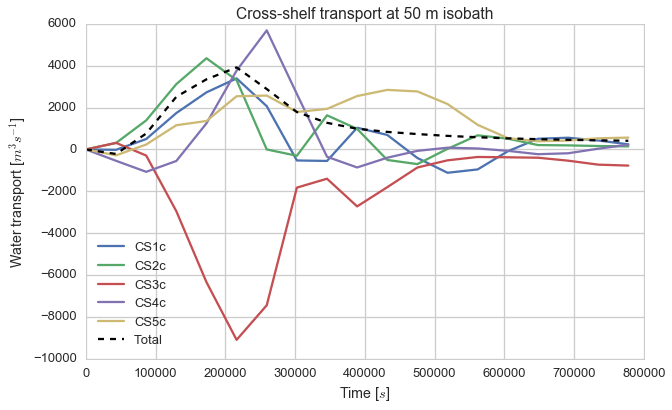

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS1c_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS1c')
(waterCS2c_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS2c')
(waterCS3c_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS3c')
(waterCS4c_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS4c')
(waterCS5c_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS5c') 

(waterCS1c_flux*grid.drF+
 waterCS2c_flux*grid.drF+
 waterCS3c_flux*grid.drF+
 waterCS4c_flux*grid.drF+
 waterCS5c_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'Total', color='k',linestyle='--')

print('at 50 m isobath')

ax = fig_looks(ax, title = 'Cross-shelf transport at 50 m isobath')


### How much water enters the domain thorugh the N boundary?

In [181]:
waterCS1d_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS1_x_slice, CS1d_y_ind, unstagger_xarray(grid.dxG, 'Yp1') , 'X')
waterCS2d_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS2_x_slice, CS1d_y_ind, unstagger_xarray(grid.dxG, 'Yp1') , 'X')
waterCS3d_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS3_x_slice, CS1d_y_ind, unstagger_xarray(grid.dxG, 'Yp1') , 'X')
waterCS4d_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS4_x_slice, CS1d_y_ind, unstagger_xarray(grid.dxG, 'Yp1') , 'X')
waterCS5d_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS5_x_slice, CS1d_y_ind, unstagger_xarray(grid.dxG, 'Yp1') , 'X')

waterCS1d_flux.name = 'WaterFlux_CS1d'
waterCS1d_flux.attrs['units'] = 'm2/s'
waterCS2d_flux.name = 'WaterFlux_CS2d'
waterCS2d_flux.attrs['units'] = 'm2/s'
waterCS3d_flux.name = 'WaterFlux_CS3d'
waterCS3d_flux.attrs['units'] = 'm2/s'
waterCS4d_flux.name = 'WaterFlux_CS4d'
waterCS4d_flux.attrs['units'] = 'm2/s'
waterCS5d_flux.name = 'WaterFlux_CS5d'
waterCS5d_flux.attrs['units'] = 'm2/s'


at 50 m isobath


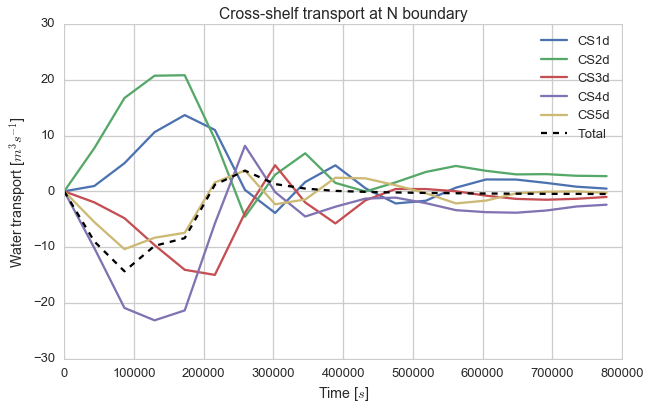

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS1d_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS1d')
(waterCS2d_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS2d')
(waterCS3d_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS3d')
(waterCS4d_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS4d')
(waterCS5d_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS5d') 

(waterCS1d_flux*grid.drF+
 waterCS2d_flux*grid.drF+
 waterCS3d_flux*grid.drF+
 waterCS4d_flux*grid.drF+
 waterCS5d_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'Total', color='k',linestyle='--')

print('at 50 m isobath')

ax = fig_looks(ax, title = 'Cross-shelf transport at N boundary')


## Alongshore transports

In [184]:
waterAS1_flux = calc_wat_transport_AS(unstagger_xarray(state03.U,'Xp1'), AS1_x_ind, AS1_y_slice, unstagger_xarray(grid.dyG, 'Xp1') , 'Y')
waterAS2_flux = calc_wat_transport_AS(unstagger_xarray(state03.U,'Xp1'), AS1_x_ind, AS2_y_slice, unstagger_xarray(grid.dyG, 'Xp1') , 'Y')
waterAS3_flux = calc_wat_transport_AS(unstagger_xarray(state03.U,'Xp1'), AS1_x_ind, AS3_y_slice, unstagger_xarray(grid.dyG, 'Xp1') , 'Y')

waterAS1_flux.name = 'WaterFlux_AS1'
waterAS1_flux.attrs['units'] = 'm2/s'
waterAS2_flux.name = 'WaterFlux_AS2'
waterAS2_flux.attrs['units'] = 'm2/s'
waterAS3_flux.name = 'WaterFlux_AS3'
waterAS3_flux.attrs['units'] = 'm2/s'



AS upstream


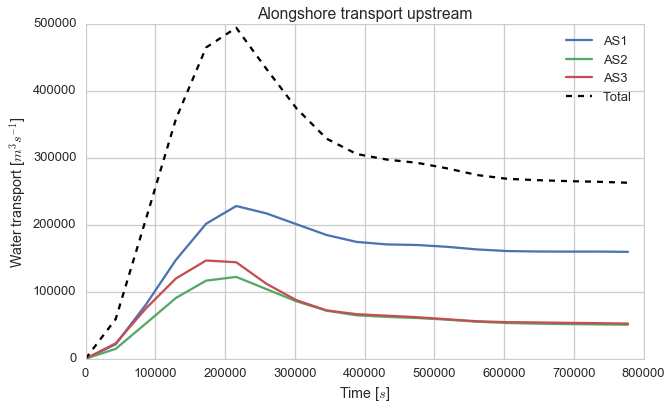

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterAS1_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'AS1')
(waterAS2_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'AS2')
(waterAS3_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'AS3')

(waterAS1_flux*grid.drF+
 waterAS2_flux*grid.drF+
 waterAS3_flux*grid.drF
).sum(dim='Z').plot(ax=ax, label = 'Total', color='k',linestyle='--')

print('AS upstream')

ax = fig_looks(ax, title = 'Alongshore transport upstream')


In [186]:
waterAS1b_flux = calc_wat_transport_AS(unstagger_xarray(state03.U,'Xp1'), AS1b_x_ind, AS1_y_slice, unstagger_xarray(grid.dyG, 'Xp1') , 'Y')
waterAS2b_flux = calc_wat_transport_AS(unstagger_xarray(state03.U,'Xp1'), AS1b_x_ind, AS2_y_slice, unstagger_xarray(grid.dyG, 'Xp1') , 'Y')
waterAS3b_flux = calc_wat_transport_AS(unstagger_xarray(state03.U,'Xp1'), AS1b_x_ind, AS3_y_slice, unstagger_xarray(grid.dyG, 'Xp1') , 'Y')

waterAS1b_flux.name = 'WaterFlux_AS1'
waterAS1b_flux.attrs['units'] = 'm2/s'
waterAS2b_flux.name = 'WaterFlux_AS2'
waterAS2b_flux.attrs['units'] = 'm2/s'
waterAS3b_flux.name = 'WaterFlux_AS3'
waterAS3b_flux.attrs['units'] = 'm2/s'



AS upstream


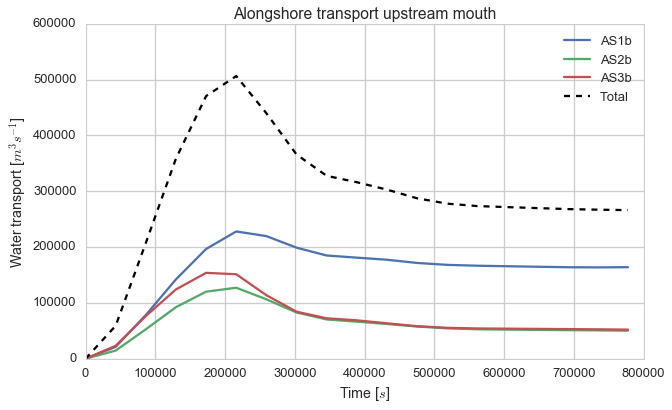

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterAS1b_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'AS1b')
(waterAS2b_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'AS2b')
(waterAS3b_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'AS3b')

(waterAS1b_flux*grid.drF+
 waterAS2b_flux*grid.drF+
 waterAS3b_flux*grid.drF
).sum(dim='Z').plot(ax=ax, label = 'Total', color='k',linestyle='--')

print('AS upstream')

ax = fig_looks(ax, title = 'Alongshore transport upstream mouth')



In [188]:
waterAS1c_flux = calc_wat_transport_AS(unstagger_xarray(state03.U,'Xp1'), AS1c_x_ind, AS1_y_slice, unstagger_xarray(grid.dyG, 'Xp1') , 'Y')
waterAS2c_flux = calc_wat_transport_AS(unstagger_xarray(state03.U,'Xp1'), AS1c_x_ind, AS2_y_slice, unstagger_xarray(grid.dyG, 'Xp1') , 'Y')
waterAS3c_flux = calc_wat_transport_AS(unstagger_xarray(state03.U,'Xp1'), AS1c_x_ind, AS3_y_slice, unstagger_xarray(grid.dyG, 'Xp1') , 'Y')

waterAS1c_flux.name = 'WaterFlux_AS1'
waterAS1c_flux.attrs['units'] = 'm2/s'
waterAS2c_flux.name = 'WaterFlux_AS2'
waterAS2c_flux.attrs['units'] = 'm2/s'
waterAS3c_flux.name = 'WaterFlux_AS3'
waterAS3c_flux.attrs['units'] = 'm2/s'



AS downstream mouth


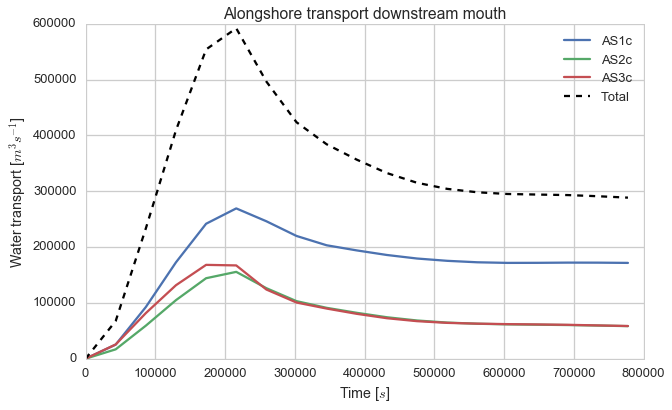

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterAS1c_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'AS1c')
(waterAS2c_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'AS2c')
(waterAS3c_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'AS3c')

(waterAS1c_flux*grid.drF+
 waterAS2c_flux*grid.drF+
 waterAS3c_flux*grid.drF
).sum(dim='Z').plot(ax=ax, label = 'Total', color='k',linestyle='--')

print('AS downstream mouth')

ax = fig_looks(ax, title = 'Alongshore transport downstream mouth')



In [194]:
waterAS1d_flux = calc_wat_transport_AS(unstagger_xarray(state03.U,'Xp1'), AS1d_x_ind, AS1_y_slice, unstagger_xarray(grid.dyG, 'Xp1') , 'Y')
waterAS2d_flux = calc_wat_transport_AS(unstagger_xarray(state03.U,'Xp1'), AS1d_x_ind, AS2_y_slice, unstagger_xarray(grid.dyG, 'Xp1') , 'Y')
waterAS3d_flux = calc_wat_transport_AS(unstagger_xarray(state03.U,'Xp1'), AS1d_x_ind, AS3_y_slice, unstagger_xarray(grid.dyG, 'Xp1') , 'Y')

waterAS1d_flux.name = 'WaterFlux_AS1'
waterAS1d_flux.attrs['units'] = 'm2/s'
waterAS2d_flux.name = 'WaterFlux_AS2'
waterAS2d_flux.attrs['units'] = 'm2/s'
waterAS3d_flux.name = 'WaterFlux_AS3'
waterAS3d_flux.attrs['units'] = 'm2/s'



AS downstream 


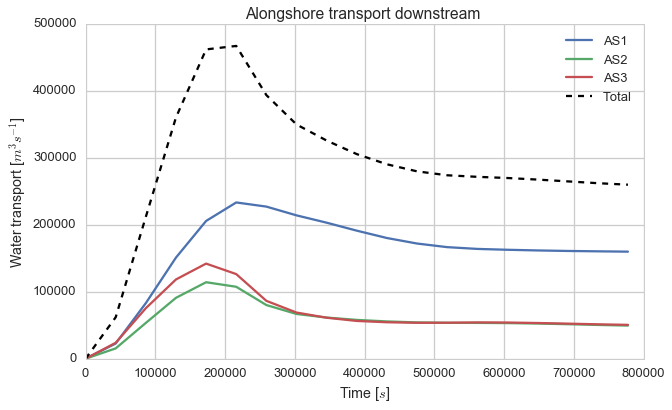

In [197]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterAS1d_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'AS1')
(waterAS2d_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'AS2')
(waterAS3d_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'AS3')

(waterAS1d_flux*grid.drF+
 waterAS2d_flux*grid.drF+
 waterAS3d_flux*grid.drF
).sum(dim='Z').plot(ax=ax, label = 'Total', color='k',linestyle='--')

print('AS downstream ')

ax = fig_looks(ax, title = 'Alongshore transport downstream ')


In [223]:
meanCS1_TD = (((waterCS1_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS2_TD =(((waterCS2_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS3_TD=(((waterCS3_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS4_TD =(((waterCS4_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS5_TD =(((waterCS5_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')

meanCST_TD =(((waterCS1_flux*grid.drF+
            waterCS2_flux*grid.drF+
            waterCS3_flux*grid.drF+
            waterCS4_flux*grid.drF+
            waterCS5_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')

meanCS1b_TD = (((waterCS1b_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS2b_TD =(((waterCS2b_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS3b_TD=(((waterCS3b_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS4b_TD =(((waterCS4b_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS5b_TD =(((waterCS5b_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')

meanCSTb_TD =(((waterCS1b_flux*grid.drF+
            waterCS2b_flux*grid.drF+
            waterCS3b_flux*grid.drF+
            waterCS4b_flux*grid.drF+
            waterCS5b_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')


meanCS1c_TD = (((waterCS1c_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS2c_TD =(((waterCS2c_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS3c_TD=(((waterCS3c_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS4c_TD =(((waterCS4c_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS5c_TD =(((waterCS5c_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')

meanCSTc_TD =(((waterCS1c_flux*grid.drF+
            waterCS2c_flux*grid.drF+
            waterCS3c_flux*grid.drF+
            waterCS4c_flux*grid.drF+
            waterCS5c_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')




In [224]:
meanCS1_ADV = (((waterCS1_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS2_ADV =(((waterCS2_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS3_ADV=(((waterCS3_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS4_ADV =(((waterCS4_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS5_ADV =(((waterCS5_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')

meanCST_ADV =(((waterCS1_flux*grid.drF+
            waterCS2_flux*grid.drF+
            waterCS3_flux*grid.drF+
            waterCS4_flux*grid.drF+
            waterCS5_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')

meanCS1b_ADV = (((waterCS1b_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS2b_ADV =(((waterCS2b_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS3b_ADV=(((waterCS3b_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS4b_ADV =(((waterCS4b_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS5b_ADV =(((waterCS5b_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')

meanCSTb_ADV =(((waterCS1b_flux*grid.drF+
            waterCS2b_flux*grid.drF+
            waterCS3b_flux*grid.drF+
            waterCS4b_flux*grid.drF+
            waterCS5b_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')


meanCS1c_ADV = (((waterCS1c_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS2c_ADV =(((waterCS2c_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS3c_ADV=(((waterCS3c_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS4c_ADV =(((waterCS4c_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')
meanCS5c_ADV =(((waterCS5c_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')

meanCSTc_ADV =(((waterCS1c_flux*grid.drF+
            waterCS2c_flux*grid.drF+
            waterCS3c_flux*grid.drF+
            waterCS4c_flux*grid.drF+
            waterCS5c_flux*grid.drF).sum(dim='Z')).isel(T=slice(1,7))).mean(dim='T')



In [234]:

data_cs = {'SB_TD':[meanCS1_TD,meanCS2_TD,meanCS3_TD,meanCS4_TD,meanCS5_TD,meanCST_TD], 
           'Iso100m_TD':[meanCS1b_TD,meanCS2b_TD,meanCS3b_TD,meanCS4b_TD,meanCS5b_TD,meanCSTb_TD],
           'Iso500m_TD':[meanCS1c_TD,meanCS2c_TD,meanCS3c_TD,meanCS4c_TD,meanCS5c_TD,meanCSTc_TD],
           'SB_ADV':[meanCS1_ADV,meanCS2_ADV,meanCS3_ADV,meanCS4_ADV,meanCS5_ADV,meanCST_ADV], 
           'Iso100m_ADV':[meanCS1b_ADV,meanCS2b_ADV,meanCS3b_ADV,meanCS4b_ADV,meanCS5b_ADV,meanCSTb_ADV],
           'Iso500m_ADV':[meanCS1c_ADV,meanCS2c_ADV,meanCS3c_ADV,meanCS4c_ADV,meanCS5c_ADV,meanCSTc_ADV]
          }
df = pd.DataFrame(data=data_cs)


In [229]:
df

,Iso100m_ADV,Iso100m_TD,Iso500m_ADV,Iso500m_TD,SB_ADV,SB_TD
0,<xarray.DataArray ()>\narray(1537.148182934178...,<xarray.DataArray ()>\narray(1537.148182934178...,<xarray.DataArray ()>\narray(1735.257366091568...,<xarray.DataArray ()>\narray(1735.257366091568...,<xarray.DataArray ()>\narray(1092.649746092634...,<xarray.DataArray ()>\narray(1092.649746092634...
1,<xarray.DataArray ()>\narray(3446.533362790776...,<xarray.DataArray ()>\narray(3446.533362790776...,<xarray.DataArray ()>\narray(2082.204302837618...,<xarray.DataArray ()>\narray(2082.204302837618...,<xarray.DataArray ()>\narray(2134.720480268857...,<xarray.DataArray ()>\narray(2134.720480268857...
2,<xarray.DataArray ()>\narray(11050.14294737285...,<xarray.DataArray ()>\narray(11050.14294737285...,<xarray.DataArray ()>\narray(-4303.37925941906...,<xarray.DataArray ()>\narray(-4303.37925941906...,<xarray.DataArray ()>\narray(38351.26488281393...,<xarray.DataArray ()>\narray(38351.26488281393...
3,<xarray.DataArray ()>\narray(-22046.2355091156...,<xarray.DataArray ()>\narray(-22046.2355091156...,<xarray.DataArray ()>\narray(1424.269609986678...,<xarray.DataArray ()>\narray(1424.269609986678...,<xarray.DataArray ()>\narray(-43188.0570931073...,<xarray.DataArray ()>\narray(-43188.0570931073...
4,<xarray.DataArray ()>\narray(5871.104252013033...,<xarray.DataArray ()>\narray(5871.104252013033...,<xarray.DataArray ()>\narray(1265.307275019715...,<xarray.DataArray ()>\narray(1265.307275019715...,<xarray.DataArray ()>\narray(3535.063568905635...,<xarray.DataArray ()>\narray(3535.063568905635...
5,<xarray.DataArray ()>\narray(-141.306764004848...,<xarray.DataArray ()>\narray(-141.306764004848...,<xarray.DataArray ()>\narray(2203.659294516516...,<xarray.DataArray ()>\narray(2203.659294516516...,<xarray.DataArray ()>\narray(1925.641584973705...,<xarray.DataArray ()>\narray(1925.641584973705...
